In [3]:
using Plots
using Statistics
using LinearAlgebra
using JSON

include("readclassjson.jl");

In [2]:
# ; wget http://ee263.stanford.edu/hw/term_by_doc.json -P data

In [4]:
bow = readclassjson("data/term_by_doc.json")

Dict{Any,Any} with 2 entries:
  "Terms" => ["appointments", "requirements", "required", "university", "medica…
  "A"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 35.0 0.0; … ; 2.0 1.0 … 4.0 1.0; 4.0…

In [5]:
A = bow["A"]
terms = bow["Terms"];

In [6]:
size(A)

(64, 128)

### a) Compute $\tilde{A}$, the normalized term-by-document matrix. Compute and plot the singular values of $\tilde{A}$.

In [7]:
column_norms = norm.([A[:,i] for i in 1:size(A)[2]])
Atilde = reduce(hcat, [A[:,i]./column_norms[i] for i in 1:size(A)[2]]);

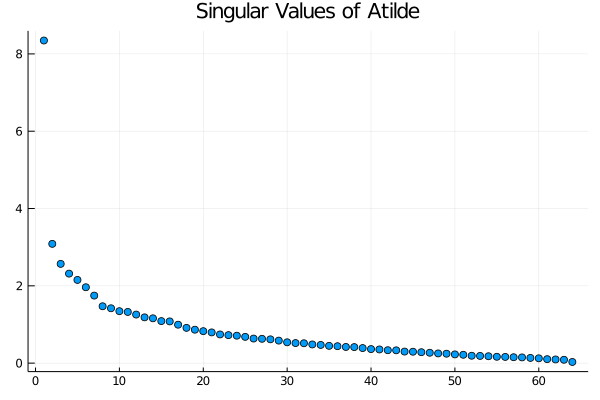

In [8]:
sigmas = svd(Atilde).S
plot(1:length(sigmas), sigmas, label=false, seriestype = :scatter)
title!("Singular Values of Atilde")


### b) Perform a query for the word students i=53 on $\tilde{A}$. What are the 5  top results? 

In [9]:
q = terms .== "students";

In [10]:
c = Atilde' * q;

In [11]:
top5Docs = sortperm(c, rev=true)[1:5]

5-element Array{Int64,1}:
 106
 105
 107
 115
 111

In [12]:
top5CosSimilarity = sort(c, rev=true)[1:5]

5-element Array{Float64,1}:
 0.6000347959260655
 0.5513075026485199
 0.49577216482210557
 0.4938338176079486
 0.4058538516854008

## c) Low-rank approximations
We will now consider low-rank approximations of $\tilde{A},$ that is
$$
\hat{A}_{r}=\min _{\hat{A}, \operatorname{rank}(\hat{A}) \leq r}\|\tilde{A}-\hat{A}\|
$$

Compute $\hat{A}_{32}, \hat{A}_{16}, \hat{A}_{8},$ and $\hat{A}_{4} .$ Perform a query for the word students on these matrices. Comment on the results.

In [13]:
decomp = svd(Atilde)
U = decomp.U
Vt = decomp.Vt
S = decomp.S;

In [14]:
size(U)

(64, 64)

In [15]:
size(Vt)

(64, 128)

In [16]:
function rankK(k)
    Sk = S
    Sk[k+1:end] .= 0
    Sk_mat = diagm(Sk)
    return(U * Sk_mat * Vt)
end

rankK (generic function with 1 method)

In [17]:
A32 = rankK(32)
A16 = rankK(16)
A8 = rankK(8)
A4 = rankK(4);

In [18]:
c32 = A32' * q;
c16 = A16' * q;
c8 = A8' * q;
c4 = A4' * q;

In [20]:
reduce(hcat, [sortperm(x, rev=true)[1:5] for x in [c32, c16, c8, c4]])

5×4 Array{Int64,2}:
 106  106  115  115
 105  107  106  105
 107  105  120  107
 115  115  107   66
 111  111  111   63

In [21]:
reduce(hcat, [sort(x, rev=true)[1:5] for x in [c32, c16, c8, c4]])

5×4 Array{Float64,2}:
 0.644528  0.547383  0.375116  0.221239
 0.49516   0.451924  0.366579  0.196093
 0.472597  0.431237  0.346216  0.191225
 0.429912  0.391048  0.332164  0.189414
 0.384641  0.374455  0.299823  0.182386

The rank 32 approximation returns the same results as the full rank $\tilde{A}$. The rank 16 approximation has the same results but in a slightly different order. The remaining two approximations contain 4/5 and 3/5 top results respectively. If our goal is top 5 performance, we can clearly afford to use an approximate $\tilde{A}$ though performance degrades in potentially important ways once we reduce the rank all the way to 4.

### d) Are there advantages of using low-rank approximations over using the full-rank matrix? (You can assume that a very large number of searches will be performed before the term-by-document matrix is updated.)

Using the notation $\tilde{A}x = \sum_{i=1}^n \sigma_iu_iv_i^Tx$, we can see matrix multiplication as a sum over two vector multiplications. When we truncate this sum to the first k terms, we can cut down on the computation required signficantly. For a large matrix problem like search, this allows for much faster result while sacrificing little in relevance. 